In [2]:
from tools import *
from config import *

In [31]:
def order_class(predictor, pred):
    res = np.zeros(pred[~np.isnan(pred)].shape[0], dtype=int)
    cc = predictor.kmeans.cluster_centers_.reshape(-1)
    classes = np.arange(cc.shape[0])
    ind = np.lexsort([cc])
    cc = cc[ind]
    classes = classes[ind]
    for c in range(cc.shape[0]):
        mask = np.argwhere(pred == classes[c])
        res[mask] = c
    return res

def class_risk(ypred, ytrue, ybin, nameDep : str, predictor) -> dict:
    if torch.is_tensor(ypred):
        ypred = ypred.detach().cpu().numpy().astype(float)
    if torch.is_tensor(ytrue):
        ytrue = ytrue.detach().cpu().numpy().astype(float)

    res = {}

    yclass = predictor.predict(ytrue)
    yclass = order_class(predictor, yclass)
    uniqueClass = np.unique(yclass)
    res[nameDep] = {}
    for c in uniqueClass:
        classIndex = np.argwhere(yclass == c)
        classPred = ypred[classIndex]
        classTrue = ypred[classIndex]
        error = abs(classPred - classTrue)
        classBin = ybin[classIndex]
        meanF = round(np.mean(classBin), 3)
        print(c, np.nansum(classBin), np.nansum(ybin))
        meanFF = round(100 * (np.nansum(classBin) / np.nansum(ybin)))
        meanP = round(np.mean(classPred), 3)
        meanT = round(np.mean(classTrue), 3)
        error = round(np.mean(error))
        res[nameDep][c] = (round(predictor.get_centroid(c)[0], 3), meanP, meanT, error, meanFF, meanF)
        
    return res[nameDep]

def get_max(influence):
    return np.nanmax(influence)

def get_sum(influence):
    return np.nansum(influence)

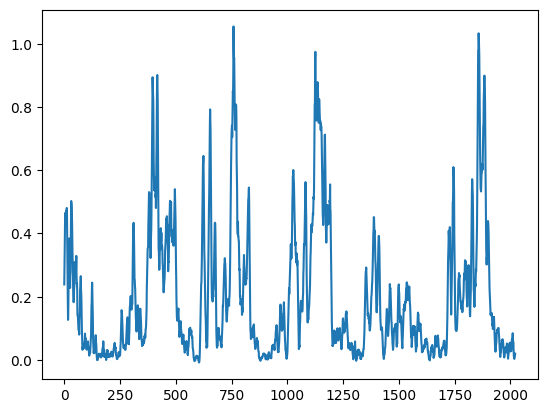

In [32]:
name_exp = 'exp_scale_2'
sinister = 'firepoint'

Y = read_object('Y_full_2.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
X = read_object('X_full_2.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
graph = read_object('graph_2.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
pos_feature, _ = create_pos_feature(graph, 6, features)
Y_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))

Y_by_date = np.asarray(Y_by_date)
plt.plot(Y_by_date)

In [33]:
allMonth = [date.split('-')[1] for date in allDates]

In [41]:
def analyse_target(scales, exps, nameExp, test):
    classs = {}
    f1s = {}
    means = {}
    means2 = {}
    for ni, scale in enumerate(scales):
        classs[scale] = {}
        p = Path(exps[ni] + '/' + nameExp+'/train/')

        Y = read_object('Y_full_'+scale+'.pkl', p)

        Y_month = [allMonth[int(di)] for di in Y[:,4]]
        graph = read_object('graph_'+scale+'.pkl', p)
        print(scale, Y[Y[:,-2] > 0].shape, Y[(Y[:,-3] > 0) & (Y[:,-2] > 0)].shape)
        print(np.unique(Y[:,4]).shape, (allDates.index('2023-01-01')))
        departements = ['departement-01-ain',
                        'departement-25-doubs',
                        'departement-78-yvelines',
                        #'departement-69-rhone'
                        ]
        bins = []
        influences = []
        mean = []
        mean2 = []
        for dep in departements:
            classs[scale][dep] = {}
            dir_predictor = p / 'influenceClustering'
            predictor = read_object(dep+'Predictor'+scale+'.pkl', dir_predictor)
            bin = Y[Y[:,3] == name2int[dep]][:,-2]
            influence = Y[Y[:,3] == name2int[dep]][:,-1]
            bins += list(bin[~np.isnan(bin)])
            influences += list(influence[~np.isnan(bin)])

            classs[scale][dep]['class'] = class_risk(influence[~np.isnan(bin)], influence[~np.isnan(bin)], bin[~np.isnan(bin)] > 0, dep, predictor)
            classs[scale][dep]['weighted_f1'] = my_f1_score(bin[~np.isnan(bin)] > 0, influence[~np.isnan(bin)], predictor.weight_array(predictor.predict(influence[~np.isnan(bin)])).reshape(-1))
            classs[scale][dep]['non_weighted_f1'] = my_f1_score(bin[~np.isnan(bin)] > 0, influence[~np.isnan(bin)], None)
            if len(mean) == 0:
                for c in [0,1,2,3,4]:
                    mean.append(classs[scale][dep]['class'][c][-1])
                    mean2.append(classs[scale][dep]['class'][c][-2])
                f1s['weighted_f1'] = classs[scale][dep]['weighted_f1'][0]
                f1s['non_weighted_f1'] = classs[scale][dep]['non_weighted_f1'][0]
            else:
                for c in [0,1,2,3,4]:
                    mean[c] += classs[scale][dep]['class'][c][-1]
                    mean2[c] += classs[scale][dep]['class'][c][-2]
                f1s['weighted_f1'] += classs[scale][dep]['weighted_f1'][0]
                f1s['non_weighted_f1'] += classs[scale][dep]['non_weighted_f1'][0]

        mean = np.asarray(mean) / len(departements)
        mean2 = np.asarray(mean2) / len(departements)
        f1s['weighted_f1'] = f1s['weighted_f1']  / len(departements)
        f1s['non_weighted_f1'] = f1s['non_weighted_f1']  / len(departements)

        means[scale] = mean
        means2[scale] = mean2

    return classs, f1s, means, means2


scales = ['2', '5', '10']
exps = ['exp_scale_2', 'exp1', 'exp1']
nameExp = 'firepoint'
test = "2023"
classs, f1s, means, means2 = analyse_target(scales, exps, nameExp, test)

2 (5938, 8) (5938, 8)
(2023,) 2029
0 11 2259
1 1037 2259
2 765 2259
3 348 2259
4 98 2259
(190995,)
0 74 1746
1 992 1746
2 395 1746
3 232 1746
4 53 1746
(202300,)
0 329 1933
1 983 1933
2 449 1933
3 157 1933
4 15 1933
(95081,)
5 (5768, 8) (5768, 8)
(2023,) 2029
0 157 2238
1 992 2238
2 669 2238
3 334 2238
4 86 2238
(80036,)
0 338 1691
1 870 1691
2 324 1691
3 124 1691
4 35 1691
(78897,)
0 462 1839
1 740 1839
2 436 1839
3 189 1839
4 12 1839
(36414,)
10 (5479, 8) (5479, 8)
(2023,) 2029
0 103 2177
1 822 2177
2 631 2177
3 418 2177
4 203 2177
(40018,)
0 250 1602
1 768 1602
2 347 1602
3 179 1602
4 58 1602
(40460,)
0 480 1700
1 574 1700
2 454 1700
3 145 1700
4 47 1700
(18207,)


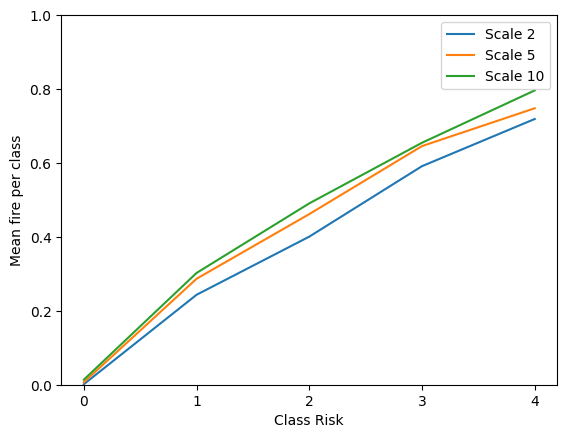

In [42]:
for sc in scales:
    plt.plot(np.arange(5), means[sc],label='Scale ' + sc)

plt.xticks([0,1,2,3,4])
plt.ylim(0, 1)
plt.ylabel('Mean fire per class')
plt.xlabel('Class Risk')
plt.legend()

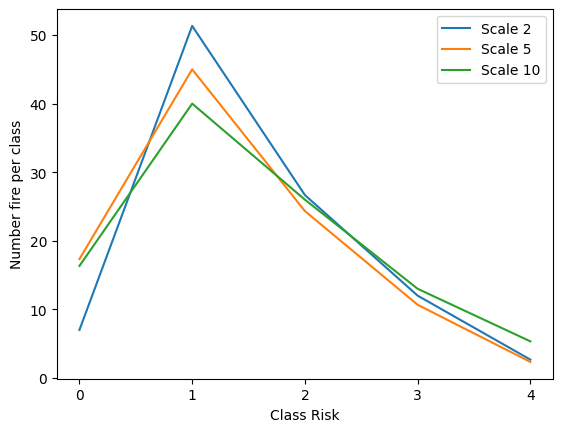

In [43]:
for sc in scales:
    plt.plot(np.arange(5), means2[sc],label='Scale ' + sc)

plt.xticks([0,1,2,3,4])
plt.ylabel('Number fire per class')
plt.xlabel('Class Risk')
plt.legend()

(13156, 324)


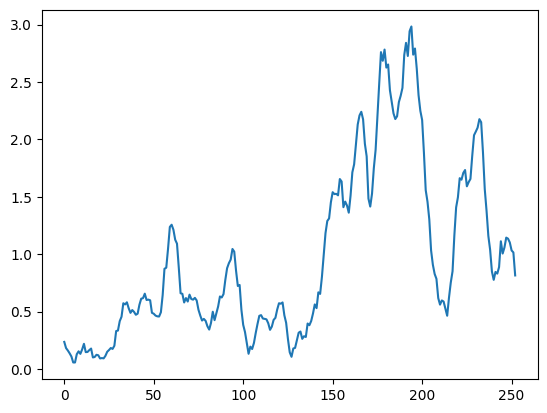

In [140]:
name_exp = 'exp1'
sinister = 'firepoint'

Y = read_object('Y_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
X = read_object('X_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
Xset = read_object('Xset.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
print(X.shape)
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
pos_feature, _ = create_pos_feature(graph, 6, features)
Y_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    
Y_by_date = np.asarray(Y_by_date)
plt.plot(Y_by_date)

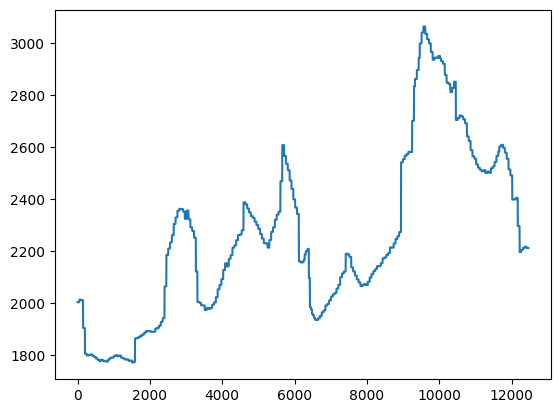

In [143]:
plt.plot(Xset[:, 300])

In [15]:
check_and_create_path(Path(name_exp + '/' + sinister + '/' + 'train') / 'varOnValue')
for var in features:
    print(var)
    plt.scatter(X[:,pos_feature[var]], Y[:,-1])
    plt.ylabel('label')
    plt.xlabel(var)
    plt.title(var)
    name = var+'.png'
    plt.savefig(Path(name_exp + '/' + sinister + '/' + 'train') / 'varOnValue' / name)
    plt.close('all')

temp
dwpt
rhum
prcp
wdir
wspd
prec24h
dc
ffmc
dmc
nesterov
munger
kbdi
isi
angstroem
bui
fwi
dailySeverityRating
temp16
dwpt16
rhum16
prcp16
wdir16
wspd16
prec24h16
days_since_rain
sum_consecutive_rainfall
sum_last_7_days
elevation
highway
population
sentinel
landcover
vigicrues
foret
Calendar
Historical
Geo
air


(38456, 324)


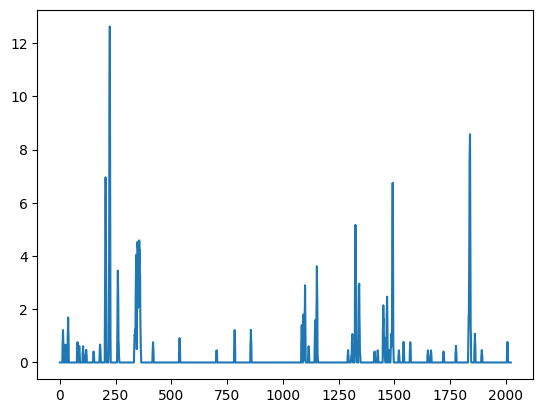

In [134]:
name_exp = 'exp1'
sinister = 'inondation'

Y = read_object('Y_full_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
X = read_object('X_full_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
print(X.shape)
pos_feature, _ = create_pos_feature(graph, 6, features)
Y_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    
Y_by_date = np.asarray(Y_by_date)
plt.plot(Y_by_date)

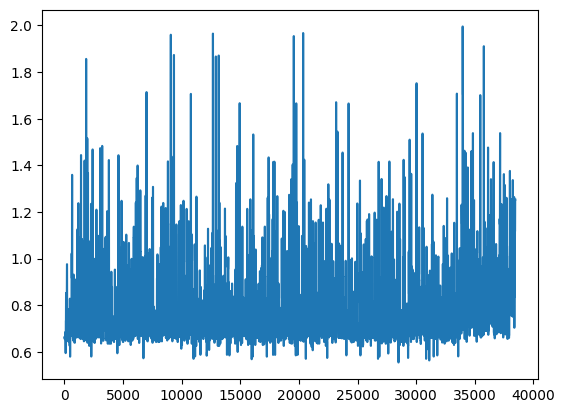

In [135]:
plt.plot(X[:,pos_feature['Calendar'] + 14])

(13156, 324)


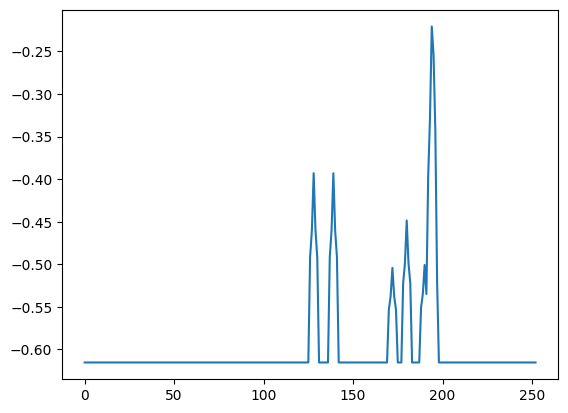

In [126]:
name_exp = 'exp1'
sinister = 'inondation'

Y = read_object('Y_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
X = read_object('X_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
Xset = read_object('Xset.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
print(X.shape)
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
pos_feature, _ = create_pos_feature(graph, 6, features)
Y_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    
Y_by_date = np.asarray(Y_by_date)
plt.plot(Y_by_date)

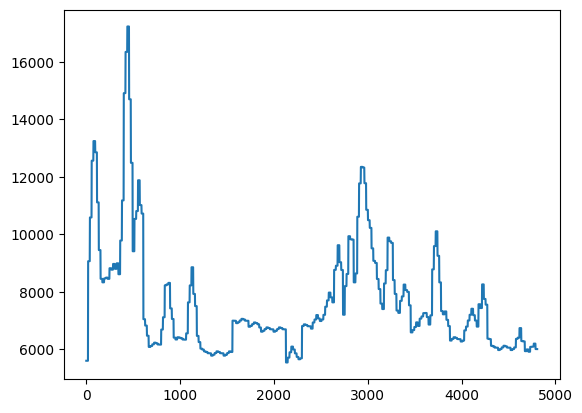

In [132]:
plt.plot(Xset[:,300])

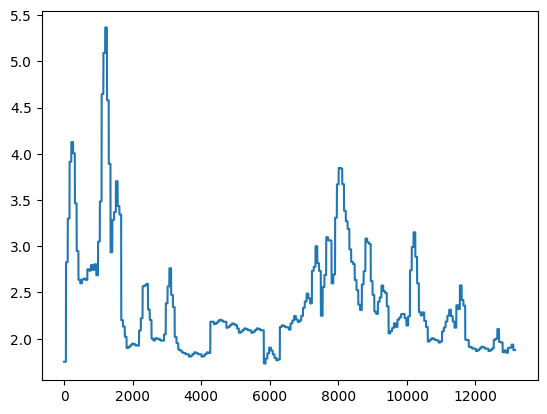

In [133]:
plt.plot(X[:,pos_feature['Calendar'] + 14 ])

In [128]:
print(np.nanmax(Xset))

17227.711612001534
